### Predicting Football Results Using Bayesian Modelling with Python and PyMC3
https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/

In [4]:
import pandas as pd
import penaltyblog as pb

In [2]:
fb = pb.scrapers.FootballData("ENG Premier League", "2020-2021")

df = fb.get_fixtures()

df.head()

SSLError: HTTPSConnectionPool(host='www.football-data.co.uk', port=443): Max retries exceeded with url: /mmz4281/2021/E0.csv (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))

In [ ]:
print(df.dtypes)

In [3]:
def right(value, count):
    return value[-count:]

In [59]:
right(df.ftr,1)

id
1621728000---wolves---man_united    A
Name: ftr, dtype: object

In [60]:
fixtures = df[["date", "team_home","team_away","fthg","ftag","ftr"]]

In [61]:
fixtures.columns = ["Date", "home_team","away_team","yg1","yg2","result"]

In [62]:
fixtures

,Date,home_team,away_team,yg1,yg2,result
id,,,,,,
1599868800---crystal_palace---southampton,2020-09-12,Crystal Palace,Southampton,1,0,H
1599868800---fulham---arsenal,2020-09-12,Fulham,Arsenal,0,3,A
1599868800---liverpool---leeds,2020-09-12,Liverpool,Leeds,4,3,H
1599868800---west_ham---newcastle,2020-09-12,West Ham,Newcastle,0,2,A
1599955200---tottenham---everton,2020-09-13,Tottenham,Everton,0,1,A
...,...,...,...,...,...,...
1621728000---liverpool---crystal_palace,2021-05-23,Liverpool,Crystal Palace,2,0,H
1621728000---man_city---everton,2021-05-23,Man City,Everton,5,0,H
1621728000---sheffield_united---burnley,2021-05-23,Sheffield United,Burnley,1,0,H


In [63]:
import numpy as np

n_teams = len(fixtures["home_team"].unique())

teams = (
    fixtures[["home_team"]]
    .drop_duplicates()
    .sort_values("home_team")
    .reset_index(drop=True)
    .assign(team_index=np.arange(n_teams))
    .rename(columns={"home_team": "team"})
)

df = (
    fixtures.merge(teams, left_on="home_team", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .merge(teams, left_on="away_team", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("Date")
)

df.head()

,Date,home_team,away_team,yg1,yg2,result,hg,ag
0,2020-09-12,Crystal Palace,Southampton,1,0,H,5,15
79,2020-09-12,West Ham,Newcastle,0,2,A,18,13
343,2020-09-12,Fulham,Arsenal,0,3,A,7,0
59,2020-09-12,Liverpool,Leeds,4,3,H,10,8
138,2020-09-13,West Brom,Leicester,0,3,A,17,9


In [64]:
TEST_SIZE = 250
train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

goals_home_obs = train["yg1"].values
goals_away_obs = train["yg2"].values
home_team = train["hg"].values
away_team = train["ag"].values

In [65]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # home advantage
    home = pm.Flat("home")

    # attack ratings
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence ratings
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # apply sum zero constraints
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # calulate theta
    home_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(atts[away_team] + defs[home_team])

    # goal expectation
    home_points = pm.Poisson("home_goals", mu=home_theta, observed=goals_home_obs)
    away_points = pm.Poisson("away_goals", mu=away_theta, observed=goals_away_obs)


In [66]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att, home]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 83 seconds.


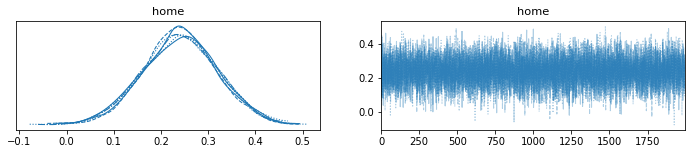

In [67]:
with model:
    pm.plot_trace(trace, var_names=["home"]);

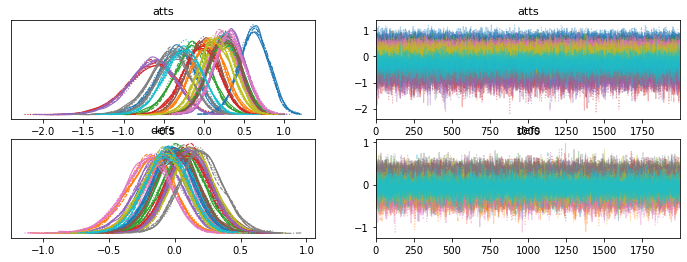

In [68]:
with model:
    pm.plot_trace(trace, var_names=["atts", "defs"]);

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_2397/841394658.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

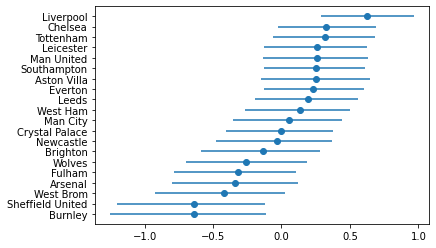

In [69]:
import arviz as az
import matplotlib.pyplot as plt

atts = (
    pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["atts"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)

plt.errorbar(
    atts["median"],
    atts["Team"],
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_2397/3768474558.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

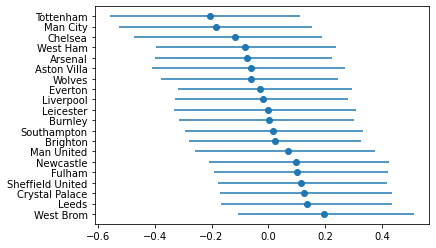

In [70]:
defs = (
    pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["defs"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=False)
)

plt.errorbar(
    defs["median"],
    defs["Team"],
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)

In [71]:
def goal_expectation(trace, home_team_id, away_team_id):   
    # get parameters
    home = np.mean(trace["home"])
    atts_home = np.mean([x[home_team_id] for x in trace["atts"]])
    atts_away = np.mean([x[away_team_id] for x in trace["atts"]])
    defs_home = np.mean([x[home_team_id] for x in trace["defs"]])
    defs_away = np.mean([x[away_team_id] for x in trace["defs"]])

    # calculate theta
    home_theta = np.exp(home + atts_home + defs_away)
    away_theta = np.exp(atts_away + defs_home)

    # return the average per team
    return home_theta, away_theta

In [72]:
goal_expectation(trace, 14, 15)

(0.6699622378563607, 1.4437814644074491)

In [73]:
goal_expectation(trace, 15, 14)

(1.8360790132317222, 0.5268177752151415)

In [74]:
from scipy.stats import poisson

def win_draw_loss(home_expectation, away_expectation, max_goals=10):
    h = poisson.pmf(range(max_goals+1), home_expectation)
    a = poisson.pmf(range(max_goals+1), away_expectation)    
    m = np.outer(h, a)

    home = np.sum(np.tril(m, -1))
    away = np.sum(np.triu(m, 1))
    draw = np.sum(np.diag(m))

    return home, draw, away   

In [75]:
def calculate_rps(df):
    rps = list()
    for idx, row in df.iterrows():
        if row["result"] == "H":
            outcome = 0
        elif row["result"] == "D":
            outcome = 1
        elif row["result"] == "A":
            outcome = 2

        h, a = goal_expectation(trace, row["hg"], row["ag"])
        predictions = win_draw_loss(h, a)

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

In [76]:
calculate_rps(test)

0.2310447496857578

In [77]:
def calculate_rps_dc(dc, df):
    rps = list()
    for idx, row in df.iterrows():
        if row["result"] == "H":
            outcome = 0
        elif row["result"] == "D":
            outcome = 1
        elif row["result"] == "A":
            outcome = 2

        predictions = dc.predict(row["home_team"], row["away_team"]).home_draw_away

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

#train["weight"] = pb.poisson.dixon_coles_weights(train["Date"],  0.001)

dc = pb.models.DixonColesGoalModel(
    train["yg1"],
    train["yg2"],
    train["home_team"],
    train["away_team"]
    #train["weight"]
)

dc.fit()

calculate_rps_dc(dc, test)


0.23071256337164922